In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('ticks')

In [2]:
from numba import njit, prange

# Equação de condução do calor 2D

Considere a equação do calor bidimensional em regime transiente, dependente do tempo $t$ (s), sem fontes geradoras de calor

$$
\rho c_p \frac{\partial T}{\partial t} = \frac{\partial}{\partial x}
    \left (k_x \frac{\partial T}{\partial x} \right ) +
    \frac{\partial}{\partial y}
    \left (k_y \frac{\partial T}{\partial y} \right )
$$

que relaciona a temperatura $T$ (K ou °C) do material com a sua capacidade térmica $c_p$ (J/(kg·K)), densidade $\rho$ (kg/m³) e condutividade térmica $k_{x,y}$ (W/(m·K)) ao longo do espaço nas direções $x$ (m) e $y$ (m).

Considerando que as propriedades térmicas e densidade do material não variam no espaço (condução isotrópica de calor, ou seja, $k_x = k_y = k$) essa equação pode ser simplificada como

$$
\frac{\partial T}{\partial t} = \kappa \left (
    \frac{\partial^2 T}{\partial x^2}  +\frac{\partial^2 T}{\partial y^2}
    \right )
$$

com a difusividade térmica (m²/s) dada por

$$
\kappa = \frac{k}{\rho c_p}.
$$

## Discretização por diferenças finitas explicitas

Discretizando o espaço em intervalos $\Delta x$, $\Delta y$ o tempo em intervalos $\Delta t$, obtem-se a equação do regime transiente do calor por diferenças finitas

$$
\frac{T_{i,j}^{n+1} - T_{i,j}^{n}}{\Delta t} = \kappa
    \left (
        \frac{T_{i,j+1}^{n} - 2 T_{i,j}^{n} + T_{i,j-1}^{n}}{(\Delta x)^2} +
        \frac{T_{i+1,j}^{n} - 2 T_{i,j}^{n} + T_{i-1,j}^{n}}{(\Delta y)^2}
    \right )
$$

$$
T_{i,j}^{n+1} =  T_{i,j}^{n} + \lambda_x ( T_{i,j+1}^{n} - 2 T_{i,j}^{n} + T_{i,j-1}^{n} ) +
        \lambda_y ( T_{i+1,j}^{n} - 2 T_{i,j}^{n} + T_{i-1,j}^{n} )
$$

que relaciona temperatura $T_{i,j}^n$ no ponto $i,j$ e no tempo $n$ com as constantes

$$
\lambda_x = \frac{\kappa \Delta t}{(\Delta x)^2}
$$

e

$$
\lambda_y = \frac{\kappa \Delta t}{(\Delta y)^2}.
$$

Nesse caso, o esquema explicito somente é estável se

$$
\max(\lambda_x, \lambda_y) \leq \frac{1}{2}
$$

## Parâmetros físicos para o problema

Nesse caso, vamos considerar uma chapa de aluminio parametrizada e discretizada conforme abaixo. Também estamos considerando temperaturas constantes (Dirichlet) em cada um dos lados do domínio (retângulo em coordenadas cartesianas). 

In [3]:
dx = 0.01 # m
dy = 0.01 # m
dt = 0.1 # s

nx = 101 # número de intervalos no eixo x
ny = 101 # número de intervalos no eixo y
nt = 101 # número de intervalos de tempo

T_l = 100 #°C - Temperatura do lado esquerdo da chapa
T_r = 50 #°C - Temperatura do lado esquerdo da chapa
T_u = 25 #°C - Temperatura de cima da chapa
T_d = 75 #°C - Temperatura de baixo da chapa


K = 9.7 * 1e-5 # Difusividade térmica do aluminio (m²/s)
               # fonte: www.electronics-cooling.com/2007/08/thermal-diffusivity/

In [4]:
lbd_x = K * dt/dx**2 # Constante lambda x
lbd_y = K * dt/dy**2 # Constante lambda y

assert lbd_x < 0.5 # Condição de estabilidade eixo x
assert lbd_y < 0.5 # Condição de estabilidade eixo y

## Parâmetros para mostrar os resultados

In [5]:
x = np.arange(nx) * dx # m
y = np.arange(ny) * dy # m
extent = [x.min(), x.max(), y.min(), y.max()]

snap_interval = 10

In [6]:
# Função para plotar os snapshots
def plot_snapshots(snaps, title):
    vmin = snaps.min()
    vmax = snaps.max()
    
    fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=5)
    plt.suptitle(title, y=0.7)

    for i in np.arange(5):
        m = np.int(snaps.shape[2]/5) * i
        im = axes[i].imshow(snaps[:,:,m].T, interpolation='nearest',
                        vmin=vmin, vmax=vmax, extent=extent, origin='upper left')
        axes[i].set_title(u't = %.3f ms' % (m*dt))
        axes[i].set_xlabel('x (m)')


    for ax in plt.gcf().axes:
        try:
            ax.label_outer()
        except:
            pass

    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, orientation='horizontal',
                label=u'Temperatura (C)')

## Implementação inocente

Essa implementação usa um laço simples para implementar a equação

$$
T_{i,j}^{n+1} =  T_{i,j}^{n} + \lambda_x ( T_{i,j+1}^{n} - 2 T_{i,j}^{n} + T_{i,j-1}^{n} ) +
        \lambda_y ( T_{i+1,j}^{n} - 2 T_{i,j}^{n} + T_{i-1,j}^{n} )
$$

veja que isso não é o recomendado em Python.

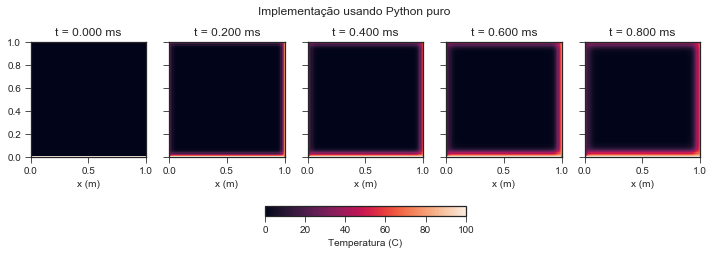

In [7]:
# Inicializando a temperatura da chapa
T = np.zeros((nx, ny))
T[:,0] = T_l
T[:,-1] = T_r
T[0,:] = T_u
T[-1,:] = T_d

snaps = np.zeros((nx, ny, (nt // snap_interval) + 1))

# Loop implementando as diferenças finitas
for n in np.arange(nt):
    if n % snap_interval == 0:
        snaps[:,:,(n // snap_interval)] = T[:,:]
        
    for i in np.arange(1, nx -1):
        for j in np.arange(1, ny -1):
            T[i,j] += lbd_x * (T[i,j+1] - 2*T[i,j] + T[i,j-1]) +\
                      lbd_y * (T[i+1,j] - 2*T[i,j] + T[i-1,j])

plot_snapshots(snaps, u'Implementação usando Python puro')

## Otimizando a implementação inocente usando Numba

É possivel compilar em tempo de execução o código em Python para Numba. Essa opção é bem poderosa

In [8]:
@njit(parallel=True, nogil=True)
def heat_equation(T, snap_interval, nx, ny, nt, lbd_x, lbd_y):
    # Loop implementando as diferenças finitas
    for n in range(nt):
        for i in prange(1, nx -1):
            for j in prange(1, ny -1):
                T[i,j] += lbd_x * (T[i,j+1] - 2*T[i,j] + T[i,j-1]) +\
                          lbd_y * (T[i+1,j] - 2*T[i,j] + T[i-1,j])

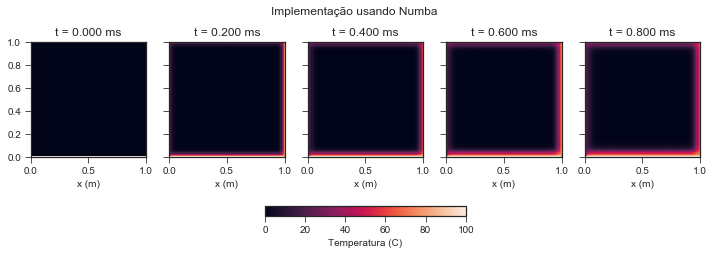

In [9]:
# Inicializando a temperatura da chapa
T = np.zeros((nx, ny))
T[:,0] = T_l
T[:,-1] = T_r
T[0,:] = T_u
T[-1,:] = T_d

snaps = np.zeros((nx, ny, (nt // snap_interval) + 1))

for n in np.arange(0, nt, snap_interval):
    if n % snap_interval == 0:
        snaps[:,:,(n // snap_interval)] = T[:,:]
    heat_equation(T, snap_interval, nx, ny, snap_interval, lbd_x, lbd_y)

plot_snapshots(snaps, u'Implementação usando Numba')

## Implementação menos inocente usando convolução

Essa implementação usa convolução bidimensional ao invés do laço simples,
desse modo a equação de condução do calor pode ser reescrita como

$$
T^{n+1} =  T^{n} + \lambda_x T^{n} *
    \begin{bmatrix}
1 \\
-2 \\
1
         \end{bmatrix} +
           \lambda_y T^{n} * [1,-2,1]
$$

esse método é bem mais eficiente que o laço simples, especialmente para
muitas amostras.

In [10]:
from scipy.ndimage.filters import convolve1d

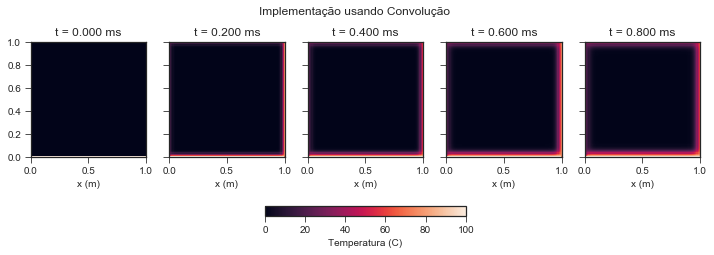

In [11]:
# Inicializando a temperatura da chapa
T = np.zeros((nx, ny))
T[:,0] = T_l
T[:,-1] = T_r
T[0,:] = T_u
T[-1,:] = T_d

snaps = np.zeros((nx, ny, (nt // snap_interval) + 1))

kernel_x = np.array([1,-2,1]) * lbd_x # Kernel no eixo x
kernel_y = np.array([1,-2,1]) * lbd_y # Kernel no eixo x

# Loop implementando as diferenças finitas
for n in np.arange(nt):
    if n % snap_interval == 0:
        snaps[:,:,(n // snap_interval)] = T[:,:]
    
    T[1:-1,1:-1] += convolve1d(T,kernel_x, axis=0, mode='constant')[1:-1,1:-1] +\
                    convolve1d(T,kernel_y, axis=1, mode='constant')[1:-1,1:-1]

plot_snapshots(snaps, u'Implementação usando Convolução')

## Comparando a velocidade das implementações

### Implementação usando Python puro

In [12]:
res = {} # Velocidade das implementações

In [13]:
%%timeit -o

# Inicializando a temperatura da chapa
T = np.zeros((nx, ny))
T[:,0] = T_l
T[:,-1] = T_r
T[0,:] = T_u
T[-1,:] = T_d

# Loop implementando as diferenças finitas
for n in np.arange(nt):
    for i in np.arange(1, nx -1):
        for j in np.arange(1, ny -1):
            T[i,j] += lbd_x * (T[i,j+1] - 2*T[i,j] + T[i,j-1]) +\
                      lbd_y * (T[i+1,j] - 2*T[i,j] + T[i-1,j])

3.33 s ± 38.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 3.33 s ± 38.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [14]:
res['Python Puro'] = _

### Implementação usando Numba

In [15]:
%%timeit -o

# Inicializando a temperatura da chapa
T = np.zeros((nx, ny))
T[:,0] = T_l
T[:,-1] = T_r
T[0,:] = T_u
T[-1,:] = T_d

heat_equation(T, snap_interval, nx, ny, nt, lbd_x, lbd_y)

4.73 ms ± 708 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 4.73 ms ± 708 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [16]:
res['Numba'] = _

### Implementação usando convolução

In [17]:
%%timeit -o

# Inicializando a temperatura da chapa
T = np.zeros((nx, ny))
T[:,0] = T_l
T[:,-1] = T_r
T[0,:] = T_u
T[-1,:] = T_d

kernel_x = np.array([1,-2,1]) * lbd_x # Kernel no eixo x
kernel_y = np.array([1,-2,1]) * lbd_y # Kernel no eixo x

# Loop implementando as diferenças finitas
for n in np.arange(nt):
    T[1:-1,1:-1] += convolve1d(T,kernel_x, axis=0, mode='constant')[1:-1,1:-1] +\
                    convolve1d(T,kernel_y, axis=1, mode='constant')[1:-1,1:-1]

15 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 15 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [18]:
res['ndimage.convolve1d'] = _

### Comparação entre os tempos

In [19]:
for key in res:
    res[key] = np.average(res[key].timings)

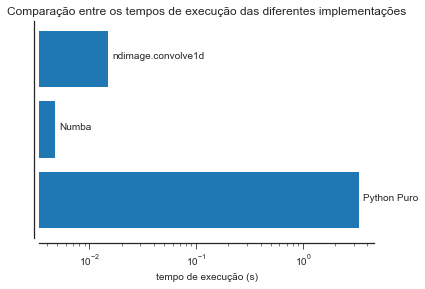

In [20]:
plt.barh(range(len(res)), list(res.values()), tick_label=res.keys())
plt.yticks([])

for i,key in enumerate(res):
    plt.text(res[key] * 1.1, i, key)

plt.xscale('log')
plt.xlabel('tempo de execução (s)')
plt.title(u'Comparação entre os tempos de execução das diferentes implementações')
sns.despine(offset=5);